# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [114]:
# I referred to the tensorflow mnist tutorial and some forum posts 
# in this assignment

# Import APIs
import random
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
#import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
FLAGS =None

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

print ("Importing done.")
### Your code implementation goes here.
### Feel free to use as many code cells as needed.


Importing done.


In [148]:
# import keras
from keras.datasets import mnist
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
print'import done'

import done


In [149]:
(ndarr, labels_raw), (test_ndarr, test_labels_raw) = mnist.load_data()
# ndarr = idx2numpy.convert_from_file('MNIST_data/train-images-idx3-ubyte.idx')
# labels_raw = idx2numpy.convert_from_file('MNIST_data/train-labels-idx1-ubyte.idx')
# test_ndarr = idx2numpy.convert_from_file('MNIST_data/t10k-images-idx3-ubyte.idx')
# test_labels_raw = idx2numpy.convert_from_file('MNIST_data/t10k-labels-idx1-ubyte.idx')
dataset_size = ndarr.shape[0]
image_height = ndarr.shape[1]
image_width = ndarr.shape[2]
print(dataset_size)

15294464/15296311 [============================>.] - ETA: 0s60000


In [150]:
train_size = 10000
valid_size = 1000
test_size = 1000

In [163]:
# Create synthetic sequences
def createSequences(ndarr, labels_raw, data_size):
    i = 0
    sequence = np.ndarray(shape=(data_size, image_height, image_width*5),
                             dtype=np.float32)
    sequence_label = []

    while i< data_size:
        sample_size = random.randint(1, 5)
        index_array = [random.randint(0, len(ndarr)-1) for _ in xrange(sample_size)]

        counter = 0
        for j in index_array:
            if counter == 0:
                temp = ndarr[j]
                temp_str = (labels_raw[j],)
            else:
                temp = np.hstack((temp, ndarr[j]))
                temp_str += (labels_raw[j],)
            
            counter += 1

        k = sample_size
        
        flag = False
        
        if k < 5:
            blank = np.zeros(shape=(image_height, image_width*(5-k)), dtype = np.float32)
            temp = np.hstack((temp, blank))
            
            while (5-k)>0:
                k += 1
                temp_str += (10,)
            
            flag = True
            
        try:
            sequence[i, :, :] = temp
        except ValueError:
            print(len(ndarr), k, temp.shape, i, flag, blank.shape)
            print(index_array)

        sequence_label.append(temp_str)

        i += 1
    sequence_label = np.array(sequence_label)
    return sequence, sequence_label

train_data1, train_label1 = createSequences(ndarr, labels_raw, train_size)
valid_data1, valid_label1 = createSequences(ndarr, labels_raw, valid_size)
test_data1, test_label1 = createSequences(test_ndarr, test_labels_raw, test_size)
print("done")
print(train_label1[1])
print('Training set', train_data1.shape, train_label1.shape)
print('Validation set', valid_data1.shape, valid_label1.shape)
print('Test set', test_data1.shape, test_label1.shape)


done
[ 1 10 10 10 10]
('Training set', (10000, 28, 140), (10000, 5))
('Validation set', (1000, 28, 140), (1000, 5))
('Test set', (1000, 28, 140), (1000, 5))


In [164]:
n = 1
print(train_label1[n])

[ 1 10 10 10 10]


In [165]:
# reformat into grayscale
label_size = 11
num_channel = 1 # grayscale
def reformat(dataset, labels):
    size = dataset.shape[0]
    dataset = dataset.reshape(
    (-1, image_height, image_width*5, num_channel)).astype(np.float32)
    #labels = (np.arange(label_size) == labels[:, None]).astype(np.float32)
    new_label_list = []
    new_labels = np.ndarray(shape=(size, 5, label_size),
                             dtype=np.float32)
    
    
    for i in range(size):
        new_labels[i] = np.eye(label_size)[labels[i]]
        
    for j in range(5):
        temp = np.ndarray(shape=(size, label_size),
                             dtype=np.float32)
        for k in range(size):
            temp[k, :] = new_labels[k][j]
            
        new_label_list.append(temp)

    return dataset, new_label_list

train_data, train_label = reformat(train_data1, train_label1)
test_data, test_label = reformat(test_data1, test_label1)

valid_data, valid_label = reformat(valid_data1, valid_label1)

train_data /= 255
valid_data /= 255
test_data /= 255
print 'done'

print('Training set', train_data.shape, train_label[0].shape)
print('Validation set', valid_data.shape)
print('Test set', test_data.shape, test_label[0].shape)

done
('Training set', (10000, 28, 140, 1), (10000, 11))
('Validation set', (1000, 28, 140, 1))
('Test set', (1000, 28, 140, 1), (1000, 11))


In [166]:
print (valid_label[0][999])

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


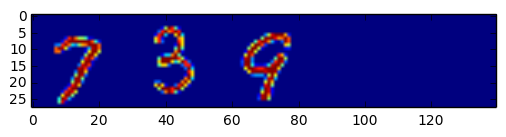

810
0
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
1
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
2
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
3
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
4
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
done


In [167]:
def displaySequence(n):
    fig=plt.figure()
    plt.imshow(test_data[n].squeeze())
    plt.show()
    print(n)
    for i in range(5):
        print(i)
        print(test_label[i][n])
    

#display random sample to check if data is ok after creating sequences
displaySequence(random.randint(0, 1000))
print'done'

In [172]:

img_rows = 28
img_cols = 140

batch_size = 64
nb_classes = 11
nb_epoch = 10
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

In [173]:
# the data, shuffled and split between train and test sets
X_train = train_data
y_train = train_label
X_valid = valid_data
y_valid = valid_label


# X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
# X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
# test_data = test_data.reshape(test_data.shape[0], img_rows, img_cols, 1)
# input_shape = (img_rows, img_cols, 1)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'validation samples')


img_input = Input(shape = X_train.shape[1:])

x = img_input
x = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], activation = 'relu', border_mode='same')(x)
x = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], activation = 'relu')(x)
x = MaxPooling2D(pool_size = pool_size) (x)
x = Dropout(0.5)(x)
x = Flatten()(x)

outs = []

for i in range(5):
    out = Dense(128, activation='relu')(x)
    out = Dense(nb_classes, activation = 'softmax', name = 'num%d'%(i+1))(x)
    outs.append(out)

model = Model(img_input, outs)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_data=(X_valid, y_valid))


('X_train shape:', (10000, 28, 140, 1))
(10000, 'train samples')
(1000, 'validation samples')
Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 80s - loss: 2.9063 - num1_loss: 0.7935 - num2_loss: 0.6969 - num3_loss: 0.5936 - num4_loss: 0.4735 - num5_loss: 0.3488 - num1_acc: 0.7458 - num2_acc: 0.7731 - num3_acc: 0.8096 - num4_acc: 0.8630 - num5_acc: 0.9106 - val_loss: 1.2589 - val_num1_loss: 0.4014 - val_num2_loss: 0.2912 - val_num3_loss: 0.2404 - val_num4_loss: 0.1797 - val_num5_loss: 0.1461 - val_num1_acc: 0.8850 - val_num2_acc: 0.9120 - val_num3_acc: 0.9180 - val_num4_acc: 0.9490 - val_num5_acc: 0.9550
Epoch 2/10
10000/10000 [==============================] - 97s - loss: 0.7981 - num1_loss: 0.2494 - num2_loss: 0.2037 - num3_loss: 0.1653 - num4_loss: 0.1136 - num5_loss: 0.0661 - num1_acc: 0.9214 - num2_acc: 0.9361 - num3_acc: 0.9470 - num4_acc: 0.9661 - num5_acc: 0.9778 - val_loss: 0.8755 - val_num1_loss: 0.2844 - val_num2_loss:

In [188]:
score = model.evaluate(test_data, test_label, verbose=1)
y_pred_list = model.predict(test_data)
print (y_pred_list[0].shape)

1000/1000 [==============================] - 2s     
(1000, 11)


In [194]:
# Testing'




correct_preds = 0

for i in range(1000): 
    for j in range(5):
        pred_list_i = [y_pred_list[j][i] for y_pred in y_pred_list[j]]
        val_list_i  = [test_label[j][i] for y_val in test_label[j]]
        matching_preds = [pred.argmax(-1) == val.argmax(-1) for pred, val in zip(pred_list_i, val_list_i)]
        count = int(np.all(matching_preds))
    correct_preds += count

total_acc = correct_preds / float(test_data.shape[0])

print('Test score:', score[0])
print('Test accuracy:', total_acc)

('Test score:', 0.5401823397874832)
('Test accuracy:', 0.987)


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** I referred to existing architectures for digit recognition. I then tweaked and tuned them for the above digit sequence recognition.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:** 
1. Convolutional Neural Network (32 filters, 3x3 kernel, same-padding) --> ReLu
2. Convolutional Neural Network (32 filters, 3x3 kernel) --> ReLu --> 2x2 Max pooling (stride 2) --> 0.5 Dropout


And then for each digit
    3. Flatten input --> Fully-connected [128] --> ReLu
    4. Fully-connected[11] --> Softmax

I used adam optimiser and categorical_crossentropy loss function.

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:** I trianed my model on 10000 synthetic number sequences of length 1-5, validated it on 1000 sequences per epoch over 20 epochs.

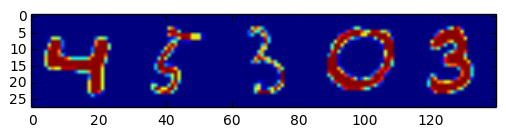

796
0
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
1
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
2
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
3
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
4
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
done


In [175]:
displaySequence(random.randint(0, 1000))
print'done'

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
### Your code implementation goes here.
### Feel free to use as many code cells as needed.

# Import APIs
import os
import tarfile
import random
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
from IPython.display import display
from PIL import Image
from scipy import ndimage
import cPickle as pickle
import scipy.io as sio
import h5py

#import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
FLAGS =None

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# import keras
from keras.datasets import mnist
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

import scipy.io
from scipy import ndimage

print'import done'

Using TensorFlow backend.


import done


In [2]:
train_image = h5py.File("./train/digitStruct.mat")

def getBox(index, hdf5_data):

    meta_data = {}
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data


print ('done')

done


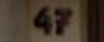

In [3]:
def getName(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    file_name = ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])
    return file_name

pic = getName(22, train_image)
img = Image.open(os.path.join('train', pic))
display(img)

{'width': [21, 22], 'top': [5, 5], 'label': [4, 7], 'left': [29, 52], 'height': [32, 32]}


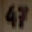

size = (32, 32)


In [4]:
def cropImage(img_path, img_boxes):
    
    img = Image.open(img_path)
    left, top, width, height = \
        img_boxes['left'], img_boxes['top'], img_boxes['width'], img_boxes['height']
    
    min_top, max_top = np.amin(top), np.amax(top)
    im_height = max_top + height[np.argmax(top)] - min_top
    min_left, max_left = np.amin(left), np.amax(left)
    im_width = max_left + width[np.argmax(left)] - min_left
    
    im_top = np.floor(min_top - 0.1 * im_height)        
    im_left = np.floor(min_left - 0.1 * im_width)
    im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), img.size[1]])
    im_right = np.amin([np.ceil(im_left + 1.2 * im_width), img.size[0]])

    return img.crop(box=(im_left, im_top, im_right, im_bottom)).resize((32, 32))

box = getBox(22, train_image)
print(box)
croppedImage = cropImage(os.path.join('train', pic), box)
display(croppedImage)
print 'size =', croppedImage.size

size = (32, 32, 1)


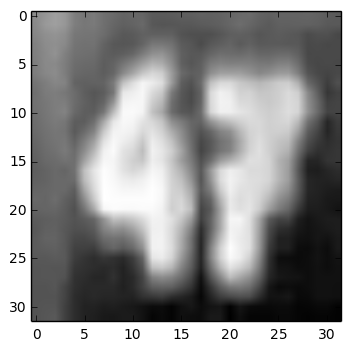

In [5]:
def grayScale(img):
    return np.dot(np.array(img, dtype=np.float32), [[0.2989],[0.5870],[0.1140]])

gray = grayScale(croppedImage)
print 'size =', gray.shape
plt.imshow(gray.reshape(32, 32), cmap=plt.cm.Greys)


size = (32, 32, 1)


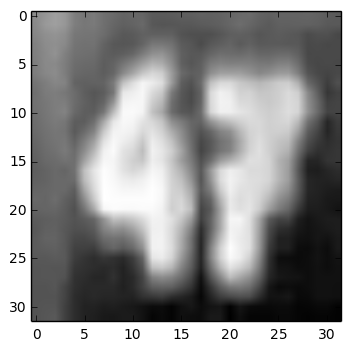

In [6]:
def Normalize(img):

    mean = np.mean(img, dtype=np.float32)
    std = np.std(img, dtype=np.float32)
    if std < 1e-4: 
        std = 1.
    return (img - mean) / std

normolized = Normalize(gray)
print 'size =', normolized.shape
plt.imshow(normolized.reshape(32, 32), cmap=plt.cm.Greys)

In [8]:
def importData(folder):

    mat_data = h5py.File(os.path.join(folder, 'digitStruct.mat'))
    size = mat_data['/digitStruct/name'].size
    dataset = np.ndarray([size, 32, 32, 1], dtype=np.float32)
    labels = np.ones([size, 6], dtype=np.int) * 10

    for i in range(size):
        _pic = getName(i, mat_data)

        _box = getBox(i, mat_data)
        cropped = cropImage(os.path.join(folder, _pic), _box)

        gray = grayScale(cropped)

        norm = Normalize(gray)
        num_digits = len(_box['label'])
        if num_digits <= 5:
            labels[i, 0] = num_digits
            for j in range(num_digits):
                labels[i, j+1] = _box['label'][j] if _box['label'][j] != 10 else 0
            dataset[i, ...] = norm[...]
        else:
            print'Skipping image with more than 5 digits.'
    return dataset, labels


train_data, train_labels = importData(folder='train')

Skipping image with more than 5 digits.


In [9]:
test_data, test_labels = importData(folder='test')

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)


((33402, 32, 32, 1), (33402, 6))
((13068, 32, 32, 1), (13068, 6))


In [9]:
#Don't execute again!
train_data = np.delete(train_data, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)

In [10]:
print(train_data.shape, train_labels.shape)

((33401, 32, 32, 1), (33401, 6))


In [12]:
label_size = 11

def oneHotEncode(labels):
#     size = labels.shape[0]
#     for i in range(size):
#         new_labels[i] = np.eye(label_size)[labels[i]]
    
#     return new_labels
    values = labels.astype(np.int16)
    n_values = np.max(values) + 1
    labels_encoded = np.eye(n_values)[values]
    labels_encoded = labels_encoded[:,:,0:]
    return labels_encoded


train_label = oneHotEncode(train_labels)
test_label = oneHotEncode(test_labels)

print(train_label.shape)
print(test_label.shape)


(33402, 6, 11)
(13068, 6, 11)


[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
[ 3  1  0  4 10 10]


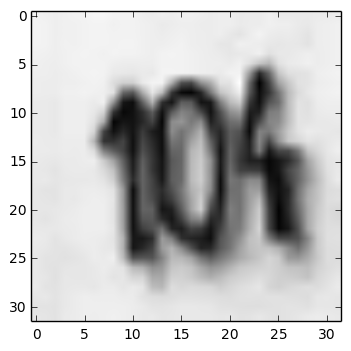

In [92]:
n = 103
print (train_label[n])
print (train_labels[n])
plt.imshow(train_data[n].squeeze(), cmap = 'gray')

In [95]:
img_rows = 32
img_cols = 32

batch_size = 64
nb_classes = 11
nb_epoch = 10
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

In [43]:
y1 = train_label[:,1,:]
y2 = train_label[:,2,:]
y3 = train_label[:,3,:]
y4 = train_label[:,4,:]
y5 = train_label[:,5,:]
y_seq_len = train_label[:,0,:]

y_train = [y_seq_len, y1, y2, y3, y4, y5]

print y_train[0][22]

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [111]:
# the data, shuffled and split between train and test sets
X_train = train_data

img_input = Input(shape = (img_rows, img_cols, 1))

x = img_input
x = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], activation = 'relu', border_mode='same')(x)
x = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], activation = 'relu')(x)
x = MaxPooling2D(pool_size = pool_size) (x)
x = Dropout(0.5)(x)
x = Flatten()(x)

outs = []

for i in range(6):
    out = Dense(128, activation='relu')(x)
    out = Dense(nb_classes, activation = 'softmax', name = 'num%d'%(i+1))(x)
    outs.append(out)

model = Model(img_input, outs)



model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split = 0.1)


Train on 30060 samples, validate on 3341 samples
Epoch 1/10
30060/30060 [==============================] - 74s - loss: 4.6346 - num1_loss: 0.5314 - num2_loss: 1.3049 - num3_loss: 1.6510 - num4_loss: 0.9073 - num5_loss: 0.2228 - num6_loss: 0.0171 - num1_acc: 0.7942 - num2_acc: 0.5672 - num3_acc: 0.4612 - num4_acc: 0.7526 - num5_acc: 0.9569 - num6_acc: 0.9977 - val_loss: 3.0678 - val_num1_loss: 0.2872 - val_num2_loss: 0.8332 - val_num3_loss: 1.1834 - val_num4_loss: 0.6035 - val_num5_loss: 0.1557 - val_num6_loss: 0.0047 - val_num1_acc: 0.8997 - val_num2_acc: 0.7480 - val_num3_acc: 0.6399 - val_num4_acc: 0.8270 - val_num5_acc: 0.9617 - val_num6_acc: 0.9997
Epoch 2/10
30060/30060 [==============================] - 72s - loss: 2.9598 - num1_loss: 0.2969 - num2_loss: 0.8108 - num3_loss: 1.1365 - num4_loss: 0.5883 - num5_loss: 0.1238 - num6_loss: 0.0036 - num1_acc: 0.8950 - num2_acc: 0.7493 - num3_acc: 0.6488 - num4_acc: 0.8280 - num5_acc: 0.9674 - num6_acc: 0.9997 - val_loss: 2.6193 - val_num

In [119]:

vy1 = test_label[:,1,:]
vy2 = test_label[:,2,:]
vy3 = test_label[:,3,:]
vy4 = test_label[:,4,:]
vy5 = test_label[:,5,:]
vy_seq_len = test_label[:,0,:] 
y_test = [vy_seq_len, vy1, vy2, vy3, vy4, vy5]

score = model.evaluate(test_data, y_test, verbose=1)
print score[0]
y_pred_list = model.predict(test_data)
print (y_pred_list[0].shape)

13068/13068 [==============================] - 9s     
2.14863161261
(13068, 11)


In [172]:

for i in range(len(model.metrics_names)):
    print model.metrics_names[i], ' is ', score[i]

loss  is  2.14863161261
num1_loss  is  0.23329944593
num2_loss  is  0.679689369017
num3_loss  is  0.866500291715
num4_loss  is  0.329933304619
num5_loss  is  0.036906421952
num6_loss  is  0.00230277941948
num1_acc  is  0.923400673401
num2_acc  is  0.793771043753
num3_acc  is  0.745485154594
num4_acc  is  0.911845730009
num5_acc  is  0.991582491582
num6_acc  is  0.999846954392


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:** I cropped the image data to 32x32 according to the bounding boxes, made them into grayscale and then normalised them. I one-hot encoded the data labels and also made the first one-hot encoding in the label array the number of digits in the image.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:** I included the number of digits to achieve good results because unlike the synthetic sequences in Step 1, the SVHN does not have a relatively consistent relation between the size of digit sequence and the space it occupies in the image. I didn't explore options that made the results worse.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:** My initial results got me accuracy at about 20% but now as shown above, it ranges from 74.5% to 99.9% on the various digits in an image. I do believe my model is doing a good enough job at classifying numbers correctly.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [13]:
import cv2

def resize(image):
    image = np.asarray(image)
    img = cv2.resize(image,(32,32))

    return img


def preprocess(image_path):
    image = Image.open(image_path)
    image = resize(image)
    gray = grayScale(image)
    norm = Normalize(gray)

    
    return norm

img11 = preprocess('11.JPG')
label11 = [2, 1, 1, 10, 10, 10]
img3 = preprocess('3.JPG')
label3 = [1, 3, 10, 10, 10, 10]
img13 = preprocess('13.JPG')
label13 = [2, 1, 3, 10, 10, 10]
img33 = preprocess('33.JPG')
label33 = [2, 3, 3, 10, 10, 10]
img180 = preprocess('180.JPG')
label180 = [3, 1, 8, 0, 10, 10]

new_data = np.ndarray([5, 32, 32, 1], dtype= np.float32)
new_label = np.ndarray([5, 6])

new_data[0] = img11
new_data[1] = img3
new_data[2] = img13
new_data[3] = img33
new_data[4] = img180
new_label[0] = label11
new_label[1] = label3
new_label[2] = label13
new_label[3] = label33
new_label[4] = label180

new_labels = oneHotEncode(new_label)

In [168]:
vy1 = new_labels[:,1,:]
vy2 = new_labels[:,2,:]
vy3 = new_labels[:,3,:]
vy4 = new_labels[:,4,:]
vy5 = new_labels[:,5,:]
vy_seq_len = new_labels[:,0,:] 
y_test = [vy_seq_len, vy1, vy2, vy3, vy4, vy5]

new_score = model.evaluate(new_data, y_test, verbose=1)

5/5 [==============================] - 0s


In [170]:
for i in range(len(model.metrics_names)):
    print model.metrics_names[i], ' is ', new_score[i]

loss  is  2.71765303612
num1_loss  is  0.038692843169
num2_loss  is  0.45733961463
num3_loss  is  1.79700016975
num4_loss  is  0.423141092062
num5_loss  is  0.00146455015056
num6_loss  is  1.48181989061e-05
num1_acc  is  1.0
num2_acc  is  0.800000011921
num3_acc  is  0.40000000596
num4_acc  is  0.800000011921
num5_acc  is  1.0
num6_acc  is  1.0


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:** The five images I took can be found in this folder under the name of '3.JPG', '11.JPG', '13.JPG', '33.JPG', '180.JPG'. The poor lighting in the image, like in 3.JPG, and the background pattern like in 180.JPG may have made the classification difficult. 

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:** My model does not perform as well on the pictures captured by me as on the SVHN dataset. On the pictures I captured, I got especially low accuracy of 40% on the second digit in the picture (num 1 is number of digits), while on the SVHN dataset I could get 74.5% for the second digit.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [24]:
def getBox2(index, hdf5_data, initSize):
    widthFactor = 32.0 / initSize[0]
    heightFactor = 32.0 / initSize[1]
    
    meta_data = {}
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    
    length = len(meta_data['label'])
    
    for key, value in meta_data.iteritems():
        if (key is'height' or key is 'top'):
            for i in range(length):
                meta_data[key][i] *= heightFactor
        elif (key is 'left' or key is 'width'):
            for i in range(length):
                meta_data[key][i] *= widthFactor
        else:
            None
        
    
    return meta_data


print ('done')

done


In [25]:
import cv2
box = getBox(22, train_image)
print(box)
print(len(box['label']))
print(box['left'][1])

{'width': [21, 22], 'top': [5, 5], 'label': [4, 7], 'left': [29, 52], 'height': [32, 32]}
2
52


104 42
{'width': [6.461538461538462, 6.76923076923077], 'top': [3.8095238095238093, 3.8095238095238093], 'label': [4, 7], 'left': [8.923076923076923, 16.0], 'height': [24.38095238095238, 24.38095238095238]}


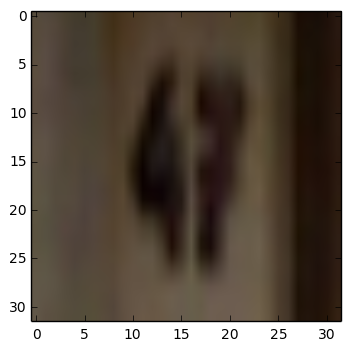

In [26]:

_pic = getName(22, train_image)
img = Image.open(os.path.join('train', _pic))
print img.size[0], img.size[1]
box = getBox2(22, train_image, img.size)
print box
img = np.asarray(img)
resized = cv2.resize(img, (32, 32))

plt.imshow(resized)

In [27]:
def importData2(folder):

    mat_data = h5py.File(os.path.join(folder, 'digitStruct.mat'))
    size = mat_data['/digitStruct/name'].size
    dataset = np.ndarray([size, 32, 32, 1], dtype=np.float32)
    box_data = np.ndarray([size, 5, 4], dtype=np.float32)

    for i in range(size):
        _pic = getName(i, mat_data)
        img = Image.open(os.path.join(folder, _pic))
        initSize = img.size
        boxes = getBox2(i, mat_data, initSize)
        
        img = np.asarray(img)
        resized = cv2.resize(img, (32, 32))

        gray = grayScale(resized)

        norm = Normalize(gray)
        length = len(boxes['label'])
        if length <= 5:
            for j in range(length):
                if j >= length:
                    for k in range(4):
                        box_data[i,j,k] = 0.0
                else:
                    box_data[i, j, 0] = boxes['left'][j]
                    box_data[i, j, 1] = boxes['top'][j]
                    box_data[i, j, 2] = boxes['width'][j]
                    box_data[i, j, 3] = boxes['height'][j]
            dataset[i, ...] = norm[...]
        else:
            print'Skipping image with more than 5 digits', i
    
    return dataset, box_data


train_data, train_labels = importData2(folder='train')
print 'done'

Skipping image with more than 5 digits 29929
done


In [28]:
print len(train_labels)

33402


In [29]:
print train_labels[22]
print getBox(22, train_image)

[[  8.92307663   3.80952382   6.46153831  24.38095284]
 [ 16.           3.80952382   6.76923084  24.38095284]
 [  0.54389656   0.45614088   0.           0.        ]
 [  0.           0.49432889   0.33703956   0.2655158 ]
 [  0.54389656   0.45614088   0.28044385   0.        ]]
{'width': [21, 22], 'top': [5, 5], 'label': [4, 7], 'left': [29, 52], 'height': [32, 32]}


In [30]:
test_data, test_labels = importData2(folder='test')
print 'done'

done


[[  9.78995419   5.7029705    4.23744297  21.86138535]
 [ 14.46575356   6.33663368   3.06849313  21.86138535]
 [ 17.82648468   3.80198026   3.79908681  21.86138535]
 [  1.11072981   1.09163582   1.13902771   1.16315961]
 [  1.05127203   1.11533177   1.12783372   1.17895555]]


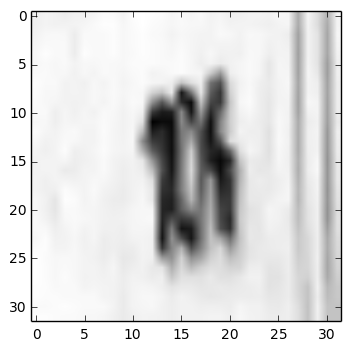

In [31]:
n = 103

print (train_labels[n])
plt.imshow(train_data[n].squeeze(), cmap = 'gray')

In [32]:
# Don't execute again!
train_labels = np.delete(train_labels, 29929, axis=0)
train_data = np.delete(train_data, 29929, axis=0)

In [33]:
print train_data.shape
print train_labels.shape

(33401, 32, 32, 1)
(33401, 5, 4)


In [34]:
y1 = train_labels[:,0,:]
y2 = train_labels[:,1,:]
y3 = train_labels[:,2,:]
y4 = train_labels[:,3,:]
y5 = train_labels[:,4,:]

y_train = [y1, y2, y3, y4, y5]

vy1 = test_labels[:,0,:]
vy2 = test_labels[:,1,:]
vy3 = test_labels[:,2,:]
vy4 = test_labels[:,3,:]
vy5 = test_labels[:,4,:]

y_test = [vy1, vy2, vy3, vy4, vy5]

print y3[22]

[ 0.54389656  0.45614088  0.          0.        ]


In [51]:
img_rows = 32
img_cols = 32

batch_size = 32
nb_epoch = 15
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

In [57]:
X_train = train_data
img_input = Input(shape = (img_rows, img_cols, 1))

x = img_input
x = Convolution2D(nb_filters*2, kernel_size[0], kernel_size[1], activation = 'relu', border_mode = 'same')(x)
x = Convolution2D(nb_filters*2, kernel_size[0], kernel_size[1], activation = 'relu')(x)
x = MaxPooling2D(pool_size = pool_size) (x)
x = Dropout(0.25)(x)
x = Convolution2D(nb_filters*4, kernel_size[0], kernel_size[1], activation = 'relu')(x)
x = Convolution2D(nb_filters*4, kernel_size[0], kernel_size[1], activation = 'relu')(x)
x = MaxPooling2D(pool_size = pool_size) (x)
x = Dropout(0.25)(x)

x = Flatten()(x)

outs = []

for i in range(5):
    out = Dense(256, init = 'normal', activation='relu')(x)
    out = Dense(128, init = 'normal', activation='relu')(out)
    out = Dense(64, init = 'normal', activation='relu')(out)
    out = Dropout(0.25)(out)
    out = Dense(4, name = 'box%d'%(i+1))(out)
    outs.append(out)

model = Model(img_input, outs)




model.compile(loss='mean_squared_error',
              optimizer='adam')


model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split = 0.1)


Train on 30060 samples, validate on 3341 samples
Epoch 1/15
30060/30060 [==============================] - 410s - loss: 97.2368 - box1_loss: 16.2379 - box2_loss: 33.3422 - box3_loss: 37.1155 - box4_loss: 9.5147 - box5_loss: 1.0264 - val_loss: 58.8943 - val_box1_loss: 7.1676 - val_box2_loss: 17.3613 - val_box3_loss: 25.6261 - val_box4_loss: 7.7664 - val_box5_loss: 0.9729
Epoch 2/15
30060/30060 [==============================] - 395s - loss: 59.3852 - box1_loss: 9.7585 - box2_loss: 19.5343 - box3_loss: 22.6113 - box4_loss: 6.4563 - box5_loss: 1.0248 - val_loss: 45.5907 - val_box1_loss: 6.3385 - val_box2_loss: 14.6642 - val_box3_loss: 18.4889 - val_box4_loss: 5.1267 - val_box5_loss: 0.9723
Epoch 3/15
30060/30060 [==============================] - 388s - loss: 50.8449 - box1_loss: 8.5091 - box2_loss: 17.0768 - box3_loss: 18.7306 - box4_loss: 5.5036 - box5_loss: 1.0248 - val_loss: 47.6708 - val_box1_loss: 5.9288 - val_box2_loss: 13.1657 - val_box3_loss: 22.8037 - val_box4_loss: 4.8003 - val

In [58]:
score = model.evaluate(test_data, y_test, verbose=1)

for i in range(len(model.metrics_names)):
    print model.metrics_names[i], ' is ', score[i]

13068/13068 [==============================] - 43s    
loss  is  nan
box1_loss  is  10.7093714694
box2_loss  is  nan
box3_loss  is  nan
box4_loss  is  nan
box5_loss  is  nan


In [59]:
_pic = getName(22, train_image)
img = Image.open(os.path.join('train', _pic))
img = np.asarray(img)
img = cv2.resize(img, (32, 32))


box = model.predict(train_data[22: 23])

for i in range(4):
    print box[i]
    
print ''
print 'Original box data is:'
print train_labels[22]


[[ 10.29332352   3.4773469    5.24233484  23.77153015]]
[[ 16.47727394   4.10656261   4.99432182  24.82776642]]
[[ 0.35707968  0.20441821  0.12030533  0.36615491]]
[[ 0.09970971  0.02583735  0.02429787  0.10155708]]

Original box data is:
[[  8.92307663   3.80952382   6.46153831  24.38095284]
 [ 16.           3.80952382   6.76923084  24.38095284]
 [  0.54389656   0.45614088   0.           0.        ]
 [  0.           0.49432889   0.33703956   0.2655158 ]
 [  0.54389656   0.45614088   0.28044385   0.        ]]


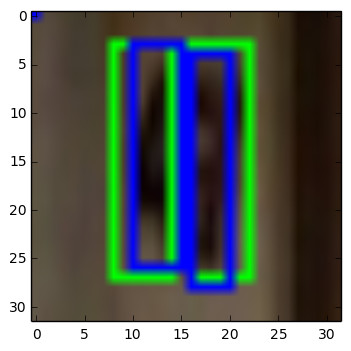

In [66]:
%matplotlib inline

box = model.predict(train_data[22: 23])

for i in range(5):
    j = 0
    for element in box[i][0]:
        box[i][0][j] = int(element)
        j+=1
    
    x = box[i][0][0]
    y = box[i][0][1]
    w = box[i][0][2]
    h = box[i][0][3]

    # blue box is the prediction while green
    plt.imshow(cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255), 1))

[[ 11.13362122   5.03992558   4.95130587  21.21034813]]
[[ 15.4328928    4.6045351    4.31895399  21.23101425]]
[[ 0.39651763  0.2234565   0.12958978  0.40261322]]
[[ 0.09970971  0.02583735  0.02429787  0.10155708]]

Original box data is:
[[ 11.91836739  17.36170197   2.93877554   7.48936176]
 [         nan          nan          nan          nan]
 [         nan          nan          nan          nan]
 [         nan          nan          nan          nan]
 [         nan          nan          nan          nan]]


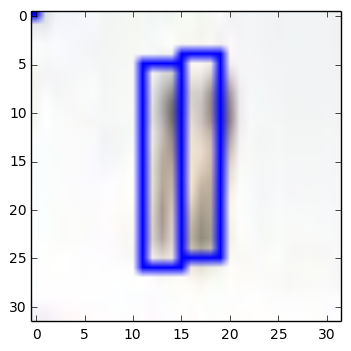

In [68]:
test_image = h5py.File("./test/digitStruct.mat")
_pic = getName(100, test_image)
img = Image.open(os.path.join('test', _pic))
img = np.asarray(img)
img = cv2.resize(img, (32, 32))


box = model.predict(train_data[100: 101])

for i in range(4):
    print box[i]
    
print ''
print 'Original box data is:'
print test_labels[22]

%matplotlib inline

for i in range(5):
    j = 0
    for element in box[i][0]:
        box[i][0][j] = int(element)
        j+=1
    
    x = box[i][0][0]
    y = box[i][0][1]
    w = box[i][0][2]
    h = box[i][0][3]

    
    plt.imshow(cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255), 1))

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:** As shown above, my model localizes numbers on the testing set reasonably well. 

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:** 

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.